In [1]:
import diff_gaussian_rasterization as dgr
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import bayes3d as b
import jax.numpy as jnp
from random import randint
import jax
from jax.scipy.spatial.transform import Rotation as R

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
def getProjectionMatrix(znear, zfar, fovX, fovY):
    tanHalfFovY = math.tan((fovY / 2))
    tanHalfFovX = math.tan((fovX / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P


intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=300.0, fy=300.0,
    cx=100.0, cy=100.0,
    near=0.01, far=2.5
)

def posevec_to_matrix(position, quat):
    return torch.cat(
        (
            torch.cat((pytorch3d.transforms.quaternion_to_matrix(quat), position.unsqueeze(1)), 1),
            torch.tensor([[0.0, 0.0, 0.0, 1.0]],device=device),
        ),
        0,
    )
def apply_transform(points, transform):
    rels_ = torch.cat(
        (
            points,
            torch.ones((points.shape[0], 1),  device=device),
        ),
        1,
    )
    return torch.einsum("ij, aj -> ai", transform, rels_)[...,:3]


def intrinsics_to_rasterizer(intrinsics, camera_pose_jax):

    fovX = jnp.arctan(intrinsics.width / 2 / intrinsics.fx) * 2.0
    fovY = jnp.arctan(intrinsics.height / 2 / intrinsics.fy) * 2.0
    tan_fovx = math.tan(fovX)
    tan_fovy = math.tan(fovY)

    proj_matrix = getProjectionMatrix(0.01, 100.0, fovX, fovY).transpose(0,1).cuda()
    view_matrix = torch.transpose(torch.tensor(np.array(b.inverse_pose(camera_pose_jax))),0,1).cuda()

    raster_settings = GaussianRasterizationSettings(
        image_height=int(intrinsics.height),
        image_width=int(intrinsics.width),
        tanfovx=tan_fovx,
        tanfovy=tan_fovy,
        bg=torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0]).cuda(),
        scale_modifier=1.0,
        viewmatrix=view_matrix,
        projmatrix=view_matrix @ proj_matrix,
        sh_degree=0,
        campos=torch.zeros(3).cuda(),
        prefiltered=False,
        debug=None
    )
    rasterizer = GaussianRasterizer(raster_settings=raster_settings)
    return rasterizer

In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7071/static/


tensor([[0.6476, 0.0034, 0.2728, 0.1794, 0.7834],
        [0.7910, 0.1427, 0.1119, 0.7619, 0.9072],
        [0.1496, 0.3162, 0.2206, 0.2894, 0.8437],
        [0.9623, 0.5202, 0.3040, 0.0154, 0.4016],
        [0.7239, 0.2085, 0.8093, 0.1810, 0.5169],
        [0.0398, 0.5062, 0.8890, 0.8834, 0.0796],
        [0.5302, 0.4987, 0.7902, 0.4247, 0.9476],
        [0.8791, 0.6703, 0.6236, 0.7331, 0.1955],
        [0.5669, 0.4745, 0.0104, 0.4414, 0.8607],
        [0.7854, 0.2883, 0.7834, 0.7328, 0.1255]], device='cuda:0')


/var/tmp/ipykernel_1163230/1879858467.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means3D = torch.tensor(torch.rand((10,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
/var/tmp/ipykernel_1163230/1879858467.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
/var/tmp/ipykernel_1163230/1879858467.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  colors_precomp_gt = torch.tensor(torch.rand((N,5)), requires_grad=True, device=de

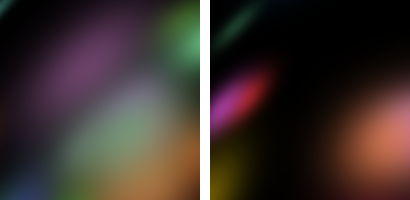

In [4]:
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=300.0, fy=300.0,
    cx=100.0, cy=100.0,
    near=0.01, far=2.5
)
rasterizer = intrinsics_to_rasterizer(intrinsics, jnp.eye(4))
means3D = torch.tensor(torch.rand((10,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
means2D = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
N = means3D.shape[0]
opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
colors_precomp_gt = torch.tensor(torch.rand((N,5)), requires_grad=True, device=device).detach()
scales = torch.tensor(-8.0 * torch.ones((N,3)), requires_grad=True, device=device)
rotations = torch.tensor(-10.0 * torch.ones((N,4)), requires_grad=True, device=device)

color,radii = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = colors_precomp_gt,
    opacities = torch.sigmoid(opacity),
    scales = torch.exp(scales),
    rotations = rotations
)
print(colors_precomp_gt)
color_gt = color.detach()
gt_viz = b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy()[...,:3] * 255.0)
gt_viz

means3D = torch.tensor(torch.rand((20,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
means2D = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
N = means3D.shape[0]
opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
colors_precomp = torch.tensor(torch.rand((N,5)), requires_grad=True, device=device)
scales = torch.tensor(-8.0 * torch.ones((N,3)), requires_grad=True, device=device)
rotations = torch.tensor(-10.0 * torch.ones((N,4)), requires_grad=True, device=device)
color,_ = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = colors_precomp,
    opacities = torch.sigmoid(opacity),
    scales = torch.exp(scales),
    rotations = rotations
)

b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy()[...,:3] * 255.0),
    gt_viz
])

0.012456557713449001: 100%|██████████| 100/100 [00:00<00:00, 369.98it/s]


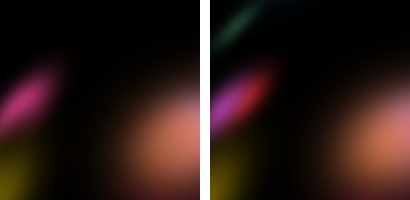

In [7]:
optimizer = torch.optim.Adam([
    {'params': [colors_precomp], 'lr': 0.01, "name": "pos"},
    {'params': [means3D], 'lr': 0.001, "name": "pos"},
], lr=0.0, eps=1e-15)

pbar = tqdm(range(100))
for _ in pbar:
    color,_ = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = colors_precomp,
        opacities = torch.sigmoid(opacity),
        scales = torch.exp(scales),
        rotations = rotations
    )
    optimizer.zero_grad()
    loss = torch.abs(color_gt - color).mean()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")
b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy()[...,:3] * 255.0),
    gt_viz
])

In [8]:
r3d_path = "/home/nishadgothoskar/bayes3d/scripts/2023-09-05--16-08-21.r3d.zip"
colors, depths, poses, intrinsics, intrinsics_depth = b.utils.load_r3d(r3d_path);

In [54]:
T =0
rasterizer = intrinsics_to_rasterizer(intrinsics_depth, jnp.eye(4))
color_gt = (torch.tensor(np.array(b.utils.resize(colors[T],intrinsics_depth.height, intrinsics_depth.width))[...,:3]).permute(2,0,1) / 255.0).cuda()
depth_gt = (torch.tensor(np.array(b.utils.resize(depths[T],intrinsics_depth.height, intrinsics_depth.width)))).cuda()
gt_viz = b.get_rgb_image(torch.permute(color_gt, (1,2,0)).cpu().detach().numpy()[...,:3] * 255.0)
gt_viz

# means3D a= torch.tensor(torch.rand((1000,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
cloud = np.array(b.apply_transform(b.unproject_depth_jit(depths[T], intrinsics_depth), jnp.eye(4)).reshape(-1,3))
# cloud = cloud[cloud[:,2] < 1.0,:]
# choice = jax.random.choice(jax.random.PRNGKey(1000), cloud.shape[0], shape=(4000,), replace=False)
# cloud = cloud[choice]
means3D = torch.tensor(cloud, requires_grad=True, device=device)
means2D = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
N = means3D.shape[0]
opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
colors_precomp = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device)
scales = torch.tensor(-15.0 * torch.ones((N,1)), requires_grad=True, device=device)
rotations = torch.tensor(-10.0 * torch.ones((N,4)), requires_grad=True, device=device)

/var/tmp/ipykernel_1163230/1480837819.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
/var/tmp/ipykernel_1163230/1480837819.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  colors_precomp = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device)
/var/tmp/ipykernel_1163230/1480837819.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(-15.0 * torch.ones((N,1)), requires_grad=True, device=device)
/var/tmp/ipykernel_1163230

0.0342065654695034: 100%|██████████| 300/300 [00:01<00:00, 257.32it/s]  


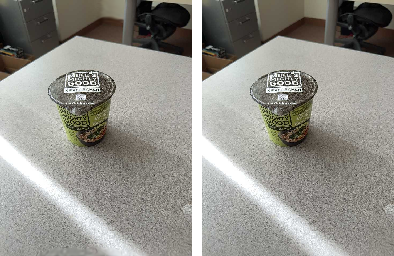

In [57]:

optimizer = torch.optim.Adam([
    {'params': [colors_precomp], 'lr': 0.01, "name": "pos"},
    # {'params': [means3D], 'lr': 0.05, "name": "pos"},
    {'params': [scales], 'lr': 0.001, "name": "pos"},
    {'params': [rotations], 'lr': 1.0, "name": "pos"},
    # {'params': [opacity], 'lr': 0.05, "name": "pos"},
], lr=0.0, eps=1e-15)

pbar = tqdm(range(300))
for _ in pbar:
    expanded_color = torch.concatenate([
        colors_precomp,
        means3D[:,2:3],
        torch.ones((means3D.shape[0],1), requires_grad=True, device=device)
    ],axis=-1)

    color,_ = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = expanded_color,
        opacities = torch.sigmoid(opacity),
        scales = torch.exp(scales).repeat((1,3)),
        rotations = rotations
    )
    optimizer.zero_grad()
    loss = torch.abs(color_gt - color[:3,...]).mean() + torch.abs(depth_gt - color[3,...]).mean() 
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")
b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy()[...,:3] * 255.0),
    gt_viz
])

In [59]:
b.clear_visualizer()
depth = jnp.array(color[3, ...].cpu().detach().numpy())
cloud = b.unproject_depth_jit(depth, intrinsics_depth).reshape(-1,3)
b.show_cloud("1", cloud * 4.0)

cloud = b.unproject_depth_jit(depths[T], intrinsics_depth).reshape(-1,3)
# b.show_cloud("2", cloud * 4.0, color=b.RED)

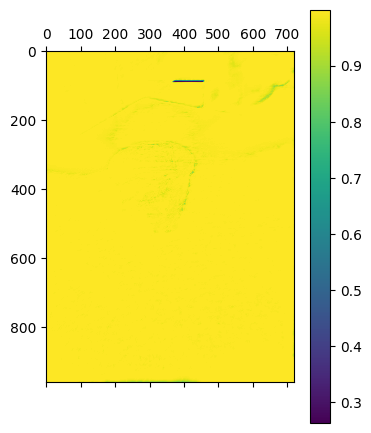

In [48]:
plt.matshow(
    color[4, ...].cpu().detach().numpy() 
)
plt.colorbar()

In [11]:
b.show_cloud("obs", 
    means3D.cpu().detach().numpy(),
    color=jnp.transpose(torch.sigmoid(colors_precomp).cpu().detach().numpy()),
    size=0.004
)

In [12]:
import pytorch3d
color_gt = (torch.tensor(np.array(b.utils.resize(colors[20],intrinsics.height, intrinsics.width))[...,:3]).permute(2,0,1) / 255.0).cuda()
gt_viz = b.get_rgb_image(torch.permute(color_gt, (1,2,0)).cpu().detach().numpy() * 255.0)

pos = torch.tensor([0.0, 0.0, 0.0], device=device, requires_grad=True)
quat = torch.tensor([1.0, 0.0, 0.0, 0.0], device=device, requires_grad=True)

optimizer = torch.optim.Adam([
    # {'params': [colors_precomp], 'lr': 0.01, "name": "pos"},
    {'params': [pos], 'lr': 0.001, "name": "pos"},
    {'params': [quat], 'lr': 0.01, "name": "pos"},
    # {'params': [scales], 'lr': 0.001, "name": "pos"},
    # {'params': [rotations], 'lr': 1.0, "name": "pos"},
    # {'params': [opacity], 'lr': 0.05, "name": "pos"},
], lr=0.0, eps=1e-15)


pbar = tqdm(range(100))
for _ in pbar:
    pose = pytorch3d.transforms.Transform3d(
        matrix=torch.vstack([torch.hstack([pytorch3d.transforms.quaternion_to_matrix(quat), pos.reshape(3,1)]), torch.tensor([0.0, 0.0, 0.0, 1.0], device=device)])
    )
    pose.transform_points(means3D)
    color,_ = rasterizer(
        means3D = pose.transform_points(means3D),
        means2D = means2D,
        shs = None,
        colors_precomp = colors_precomp,
        opacities = torch.sigmoid(opacity),
        scales = torch.exp(scales),
        rotations = rotations
    )
    optimizer.zero_grad()
    loss = torch.abs(color_gt - color).mean()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")
b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy() * 255.0),
    gt_viz
])

ModuleNotFoundError: No module named 'pytorch3d'

In [ ]:
optimizer = torch.optim.Adam([
    {'params': [colors_precomp], 'lr': 0.01, "name": "pos"},
    # {'params': [means3D], 'lr': 0.05, "name": "pos"},
    {'params': [scales], 'lr': 0.001, "name": "pos"},
    {'params': [rotations], 'lr': 1.0, "name": "pos"},
    # {'params': [opacity], 'lr': 0.05, "name": "pos"},
], lr=0.0, eps=1e-15)

pbar = tqdm(range(100))
for _ in pbar:
    color,_ = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = colors_precomp,
        opacities = torch.sigmoid(opacity),
        scales = torch.exp(scales).repeat((1,3)),
        rotations = rotations
    )
    optimizer.zero_grad()
    loss = torch.abs(color_gt - color).mean()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")
b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy() * 255.0),
    gt_viz
])

In [9]:
from bayes3d.viz.open3dviz import Open3DVisualizer
visualizer = Open3DVisualizer(intrinsics)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x564f3dd5c690 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


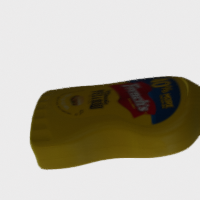

In [10]:
import os
import open3d as o3d
model_dir = os.path.join(b.utils.get_assets_dir(), "ycb_video_models/models")
i = 4
mesh_path = os.path.join(model_dir, b.utils.ycb_loader.MODEL_NAMES[i], "textured.obj")
mesh  = o3d.io.read_triangle_model(mesh_path)
visualizer.render.scene.clear_geometry()
pose = b.distributions.gaussian_vmf(jax.random.PRNGKey(1000),b.transform_from_pos(jnp.array([0.0, 0.0, 0.3])), 0.01, 1.0)
mesh.meshes[0].mesh.transform(pose)
visualizer.render.scene.add_model(f"m", mesh)
mesh.meshes[0].mesh.transform(jnp.linalg.inv(pose))
rgbd = visualizer.capture_image(intrinsics, jnp.eye(4))
b.get_rgb_image(rgbd.rgb)

/var/tmp/ipykernel_430444/312588735.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
/var/tmp/ipykernel_430444/312588735.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  colors_precomp = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device)
/var/tmp/ipykernel_430444/312588735.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(-12.0 * torch.ones((N,3)), requires_grad=True, device=device)
/var/tmp/ipykernel_430444/312588

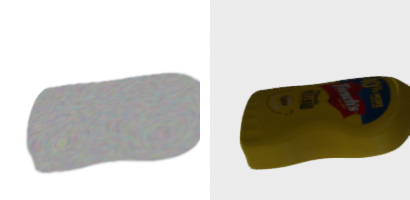

In [11]:
color_gt = (torch.tensor(np.array(rgbd.rgb)[...,:3]).permute(2,0,1) / 255.0).cuda()
gt_viz = b.get_rgb_image(torch.permute(color_gt, (1,2,0)).cpu().detach().numpy() * 255.0)
gt_viz

# means3D = torch.tensor(torch.rand((1000,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
cloud = np.array(b.unproject_depth_jit(rgbd.depth, rgbd.intrinsics).reshape(-1,3))
cloud = cloud[cloud[:,2] < intrinsics.far,:]
# choice = jax.random.choice(jax.random.PRNGKey(1000), cloud.shape[0], shape=(100,), replace=False)
# cloud = cloud[choice]
means3D = torch.tensor(cloud, requires_grad=True, device=device)

means2D = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
N = means3D.shape[0]
opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
colors_precomp = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device)
scales = torch.tensor(-12.0 * torch.ones((N,3)), requires_grad=True, device=device)
rotations = torch.tensor(-10.0 * torch.ones((N,4)), requires_grad=True, device=device)

color,_ = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = torch.sigmoid(colors_precomp),
    opacities = torch.sigmoid(opacity),
    scales = torch.exp(scales),
    rotations = rotations
)
b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy() * 255.0),
    gt_viz
])

0.05333171412348747: 100%|██████████| 100/100 [00:00<00:00, 342.25it/s]


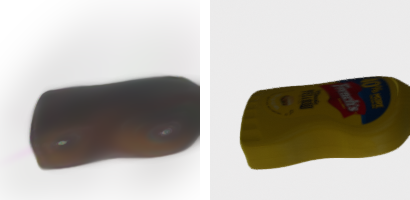

In [12]:
optimizer = torch.optim.Adam([
    {'params': [colors_precomp], 'lr': 0.01, "name": "pos"},
    # {'params': [means3D], 'lr': 0.05, "name": "pos"},
    {'params': [scales], 'lr': 0.01, "name": "pos"},
    {'params': [rotations], 'lr': 0.1, "name": "pos"},
], lr=0.0, eps=1e-15)

pbar = tqdm(range(100))
for _ in pbar:
    color,_ = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = torch.sigmoid(colors_precomp),
        opacities = torch.sigmoid(opacity),
        scales = torch.exp(scales),
        rotations = rotations
    )
    optimizer.zero_grad()
    loss = torch.abs(color_gt - color).mean()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")
b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy() * 255.0),
    gt_viz
])

In [13]:
b.show_cloud("obs", 
    means3D.cpu().detach().numpy(),
    color=jnp.transpose(torch.sigmoid(colors_precomp).cpu().detach().numpy()),
    size=0.001)
    # color=jnp.transpose(color.reshape(-1,3))/255.0, 

    # size=0.003)

In [37]:
!pip install "git+https://github.com/facebookresearch/pytorch3d.git"

  Cloning https://github.com/facebookresearch/pytorch3d.git to /var/tmp/pip-req-build-o0l31fal
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /var/tmp/pip-req-build-o0l31fal
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 6b8766080d2c331a05abbddbf3c7332dbb9df791
  Preparing metadata (setup.py) ... done

0.036051440984010696: 100%|██████████| 100/100 [00:00<00:00, 167.38it/s]


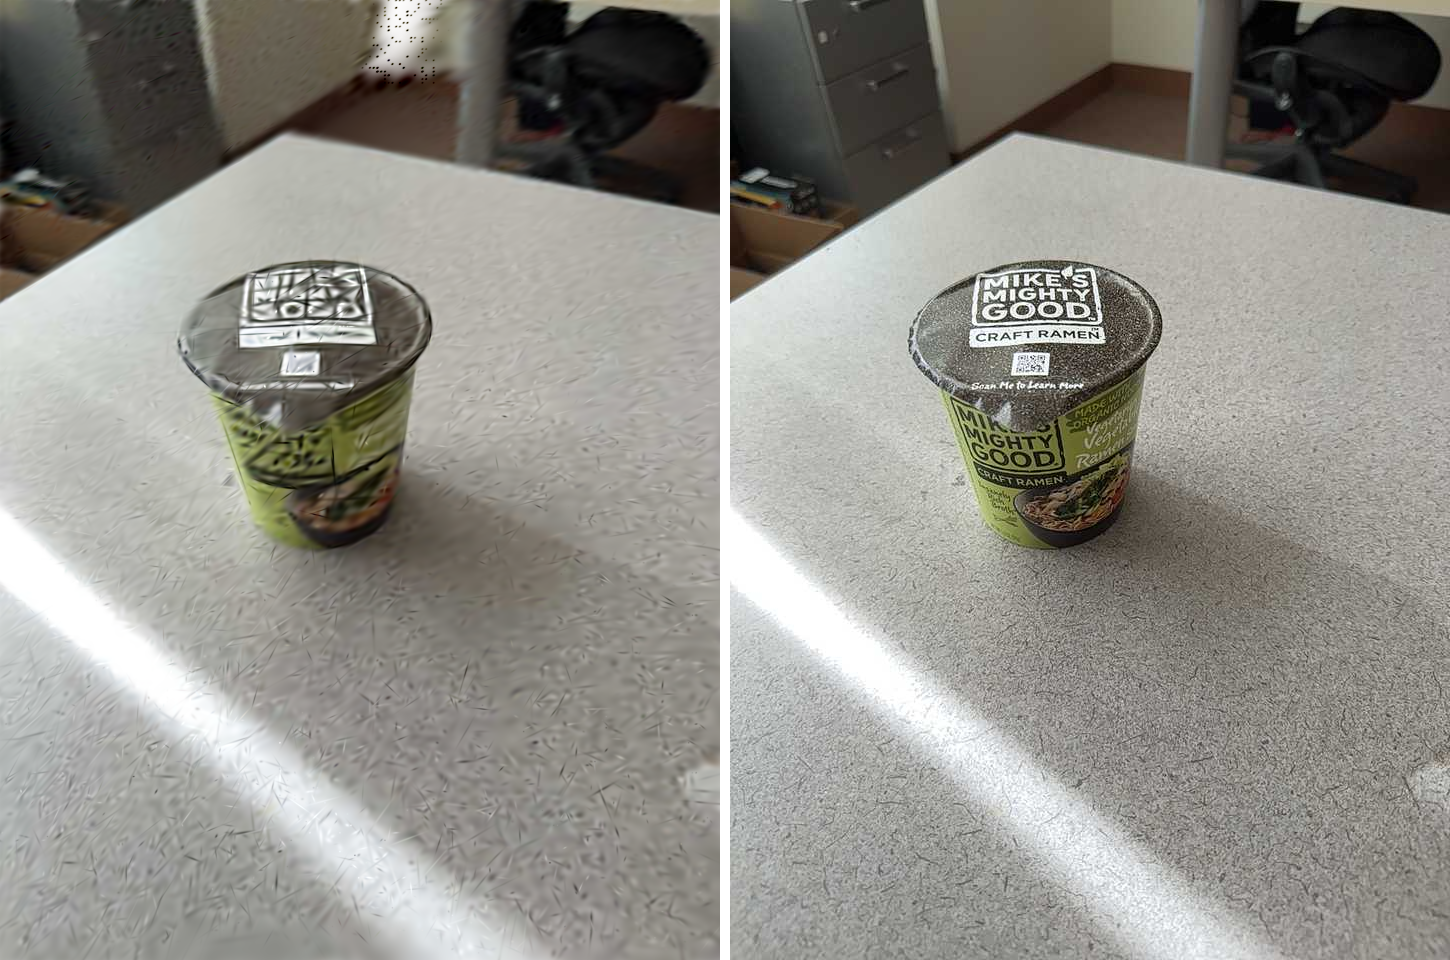

In [21]:
b.clear()
b.show_cloud("obs", 
    means3D.cpu().detach().numpy() * 0.3,
    color=jnp.transpose(torch.sigmoid(colors_precomp).cpu().detach().numpy()),
    size=0.002)
    # color=jnp.transpose(color.reshape(-1,3))/255.0, 

    # size=0.003)

0.08097682893276215:   0%|          | 0/100 [00:00<?, ?it/s]

0.0761624351143837: 100%|██████████| 100/100 [00:00<00:00, 137.03it/s]


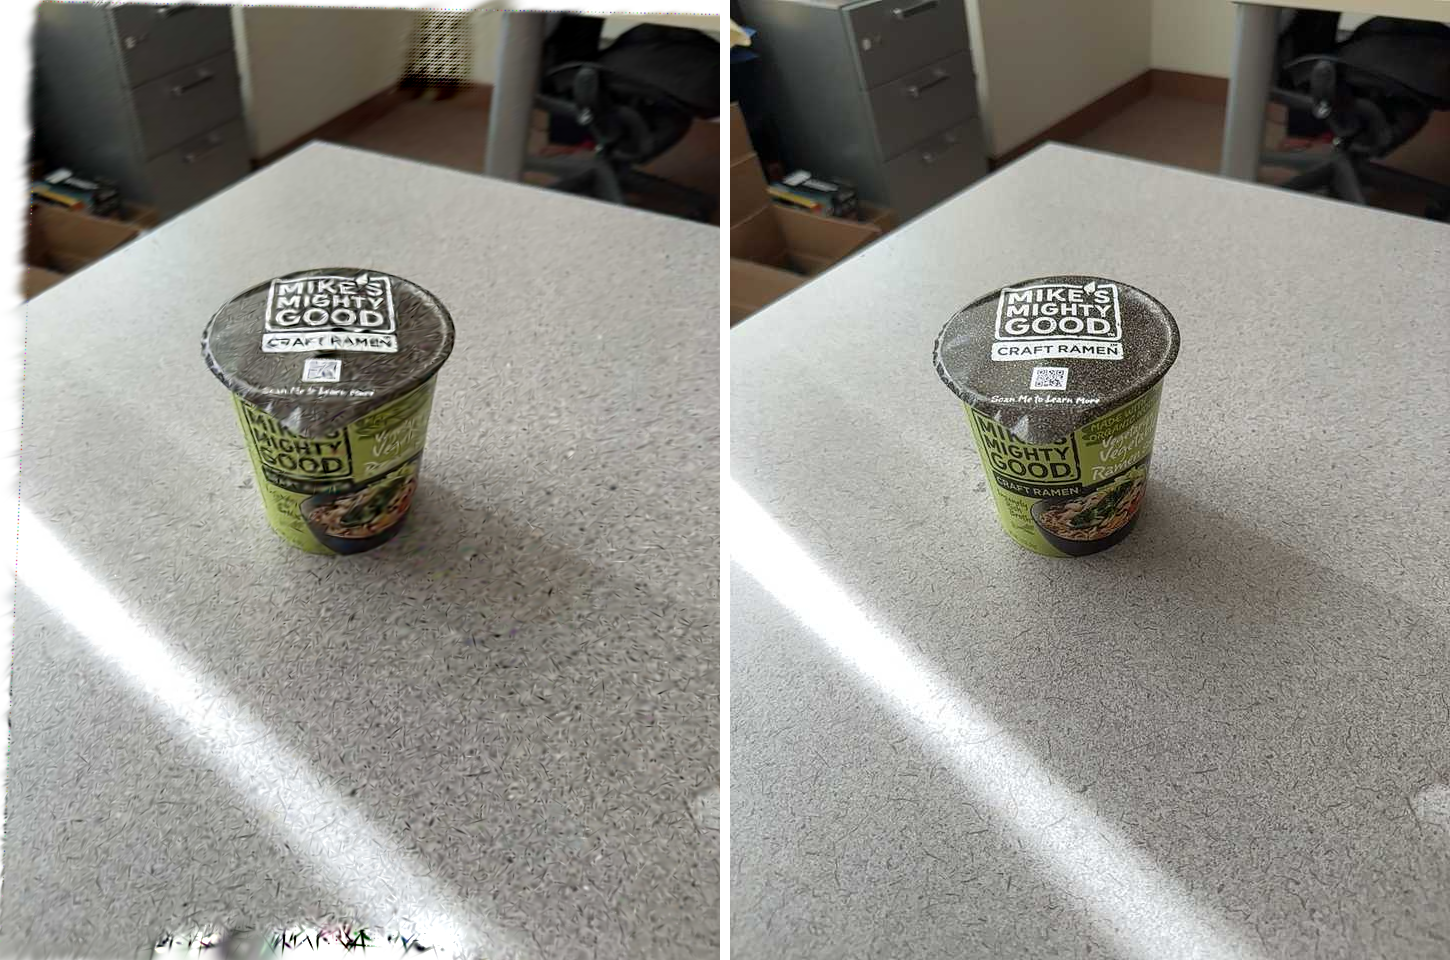

In [37]:
color_gt = (torch.tensor(np.array(b.utils.resize(colors[20],intrinsics.height, intrinsics.width))[...,:3]).permute(2,0,1) / 255.0).cuda()
gt_viz = b.get_rgb_image(torch.permute(color_gt, (1,2,0)).cpu().detach().numpy() * 255.0)


pos = torch.tensor([0.0, 0.0, 0.0], device=device, requires_grad=True)
quat = torch.tensor([1.0, 0.0, 0.0, 0.0], device=device, requires_grad=True)


optimizer = torch.optim.Adam([
    # {'params': [colors_precomp], 'lr': 0.01, "name": "pos"},
    {'params': [pos], 'lr': 0.001, "name": "pos"},
    {'params': [quat], 'lr': 0.01, "name": "pos"},
    # {'params': [scales], 'lr': 0.001, "name": "pos"},
    # {'params': [rotations], 'lr': 1.0, "name": "pos"},
    # {'params': [opacity], 'lr': 0.05, "name": "pos"},
], lr=0.0, eps=1e-15)


pbar = tqdm(range(100))
for _ in pbar:
    pose = pytorch3d.transforms.Transform3d(
        matrix=torch.vstack([torch.hstack([pytorch3d.transforms.quaternion_to_matrix(quat), pos.reshape(3,1)]), torch.tensor([0.0, 0.0, 0.0, 1.0], device=device)])
    )
    pose.transform_points(means3D)
    color,_ = rasterizer(
        means3D = pose.transform_points(means3D),
        means2D = means2D,
        shs = None,
        colors_precomp = colors_precomp,
        opacities = torch.sigmoid(opacity),
        scales = torch.exp(scales),
        rotations = rotations
    )
    optimizer.zero_grad()
    loss = torch.abs(color_gt - color).mean()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")
b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy() * 255.0),
    gt_viz
])

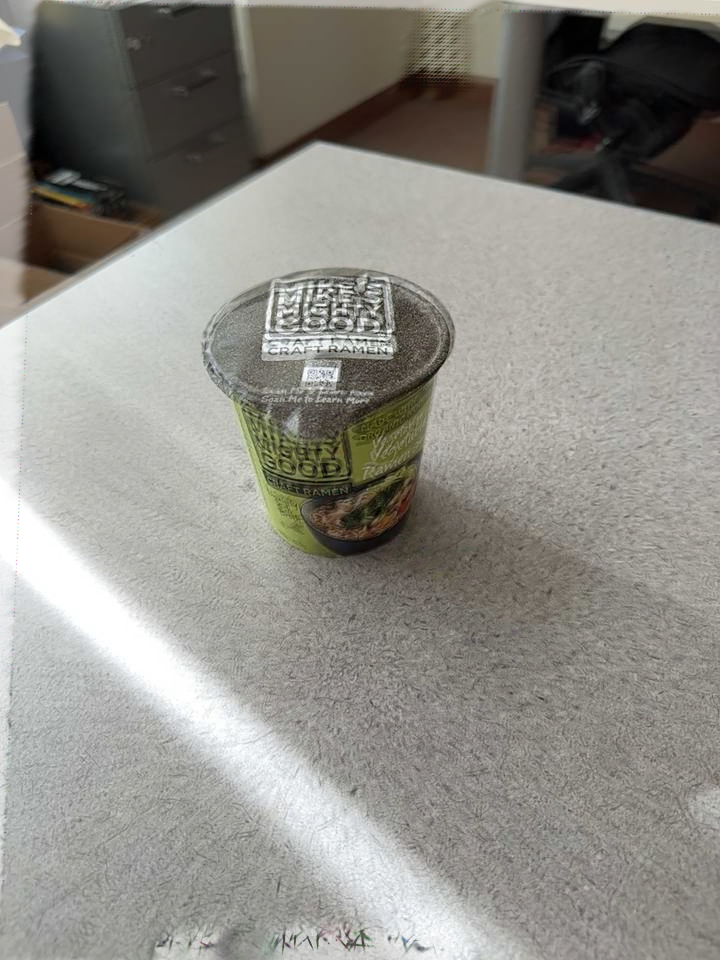

In [50]:
b.overlay_image(
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy() * 255.0),
    gt_viz
)

In [28]:
b.clear()
b.show_pose("1", poses[0])
b.show_pose("2", poses[20])
b.show_pose("3", pose.get_matrix().cpu().detach().numpy())

In [25]:
pose.get_matrix()

tensor([[[ 0.9990,  0.0361, -0.0248, -0.0458],
         [-0.0364,  0.9993, -0.0106, -0.0027],
         [ 0.0244,  0.0115,  0.9996,  0.0225],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
       grad_fn=<CloneBackward0>)

In [86]:
b.clear()
b.show_cloud("obs", 
    means3D.cpu().detach().numpy() * 0.3,
    color=jnp.transpose(torch.sigmoid(colors_precomp).cpu().detach().numpy()),
    size=0.002)
    # color=jnp.transpose(color.reshape(-1,3))/255.0, 

    # size=0.003)